In [1]:
import pandas as pd
from ETL import ETL
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore


In [87]:
df = pd.read_csv('dataset/2012.csv')

In [88]:
df = ETL(df)

c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'FL_MON'] = df['FL_DATE'].apply(lambda x: x.month)
c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'FL_DAY'] = df['FL_DATE'].apply(lambda x: x.day)
c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [89]:
# Selezioniamo le colonne di interesse e gestiamo eventuali valori nulli
df.dropna(subset=['DEP_DELAY', 'ARR_DELAY'], inplace=True)

In [82]:
# Supponiamo che il tuo DataFrame si chiami df
Q1 = df[['DEP_DELAY', 'ARR_DELAY']].quantile(0.25)  # 25° percentile
Q3 = df[['DEP_DELAY', 'ARR_DELAY']].quantile(0.75)  # 75° percentile
IQR = Q3 - Q1  # calcola l'IQR

# Definisci i limiti per considerare un outlier
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtra i dati rimuovendo gli outliers
df = df[~((df[['DEP_DELAY', 'ARR_DELAY']] < lower_limit) | (df[['DEP_DELAY', 'ARR_DELAY']] > upper_limit)).any(axis=1)]

In [90]:
# Calcola il Z-score per le colonne di interesse
z_scores = zscore(df[['DEP_DELAY', 'ARR_DELAY']])

# Imposta una soglia per considerare un valore come outlier
threshold = 5  # Puoi cambiare questo valore

# Filtra il DataFrame rimuovendo le righe con outliers
df.drop(index=df[(abs(z_scores) > threshold).any(axis=1)].index, inplace=True)

# K-Means

In [ ]:
# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['DEP_DELAY', 'ARR_DELAY']])

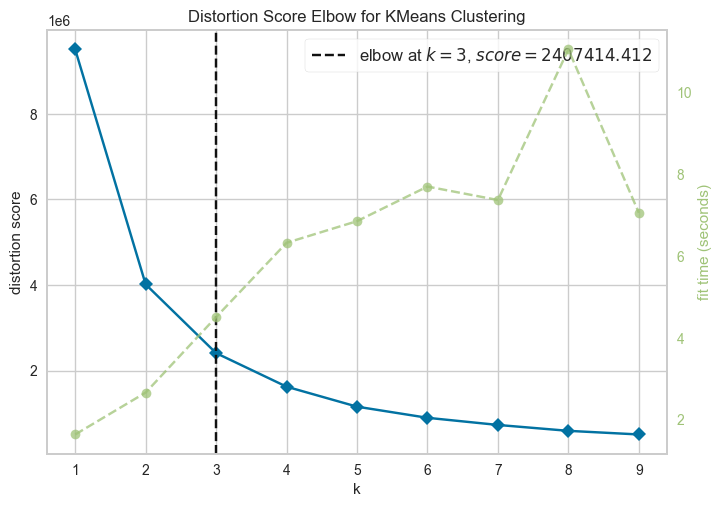

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Creazione del modello KMeans
model = KMeans(random_state=42)

# Utilizzo di KElbowVisualizer per determinare il numero ottimale di cluster
visualizer = KElbowVisualizer(model, k=(1, 10), metric='distortion', timings=True)

# Fit dei dati e visualizzazione del grafico
visualizer.fit(data_scaled)
visualizer.show()

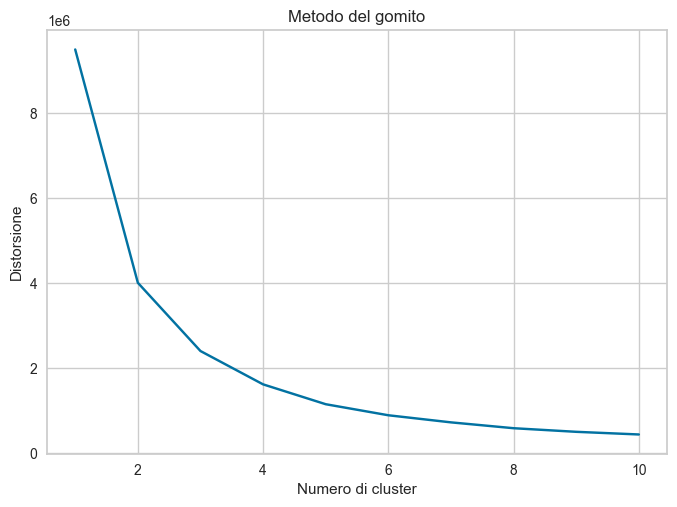

In [62]:
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions)
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito')
plt.show()

In [85]:
# Selezioniamo le colonne di interesse per il clustering
data = df[['DEP_DELAY', 'ARR_DELAY']]

# Standardizzazione dei dati per evitare che le variabili con valori più alti influenzino il clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Applicazione del KMeans per il clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(data_scaled)
centroids_kmeans = kmeans.cluster_centers_


In [76]:
# Selezionare solo le colonne numeriche per il calcolo della media
cluster_summary = df.groupby('Cluster')[['DEP_DELAY', 'ARR_DELAY']].agg(['mean', 'max', 'min'])

# Stampare il riepilogo dei cluster
print(cluster_summary)


          DEP_DELAY                 ARR_DELAY              
               mean    max    min        mean    max    min
Cluster                                                    
0         -4.354502    0.0 -120.0   -9.765204   30.0 -122.0
1         58.559641  109.0  -10.0   56.841394  162.0   15.0
2        112.040749  156.0   27.0  110.628621  162.0   51.0
3         18.542251   54.0  -23.0   26.238213  122.0   15.0


In [65]:
# Dopo aver osservato le caratteristiche, assegna nomi descrittivi ai cluster
# Supponiamo che dopo l'osservazione, i cluster possano essere classificati come Alto, Medio e Basso Rendimento
cluster_names = {0: 'Puntuale o in anticipo', 1: 'Ritardo Grave', 2: 'Ritardo estremamente grave', 3: 'Ritardo' }

df['Cluster Nome'] = df['Cluster'].map(cluster_names)

C:\Users\dswal\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


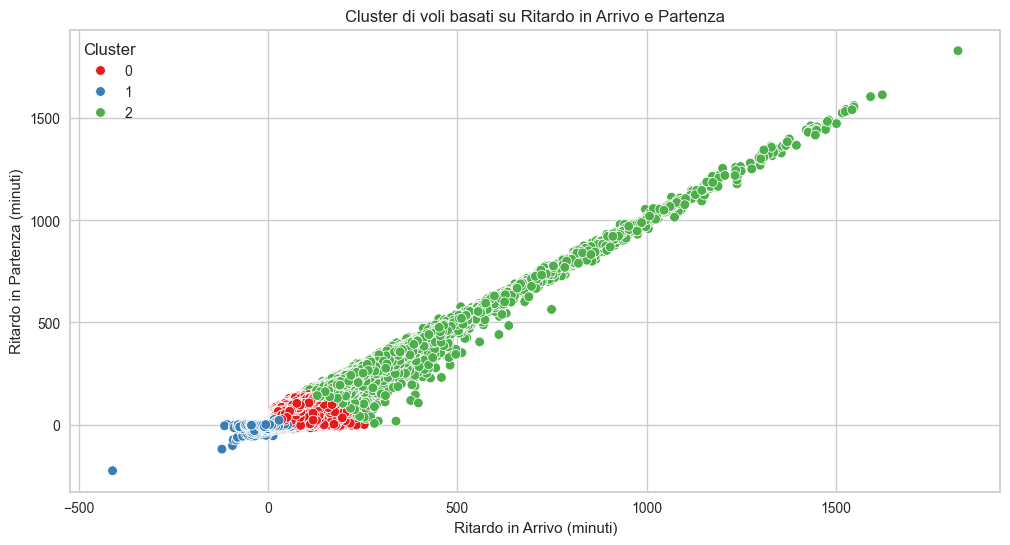

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ARR_DELAY', y='DEP_DELAY', hue='Cluster', data=df, palette='Set1', s=50)

# Aggiungi i centroidi al grafico (con simbolo e colore diverso)
# Centroidi saranno punti rossi con un marker diverso
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], c='black', marker='X', s=200, label='Centroidi', edgecolor='white')

plt.title('Cluster di voli basati su Ritardo in Arrivo e Partenza')
plt.xlabel('Ritardo in Arrivo (minuti)')
plt.ylabel('Ritardo in Partenza (minuti)')
plt.legend(title='Cluster')
plt.show()

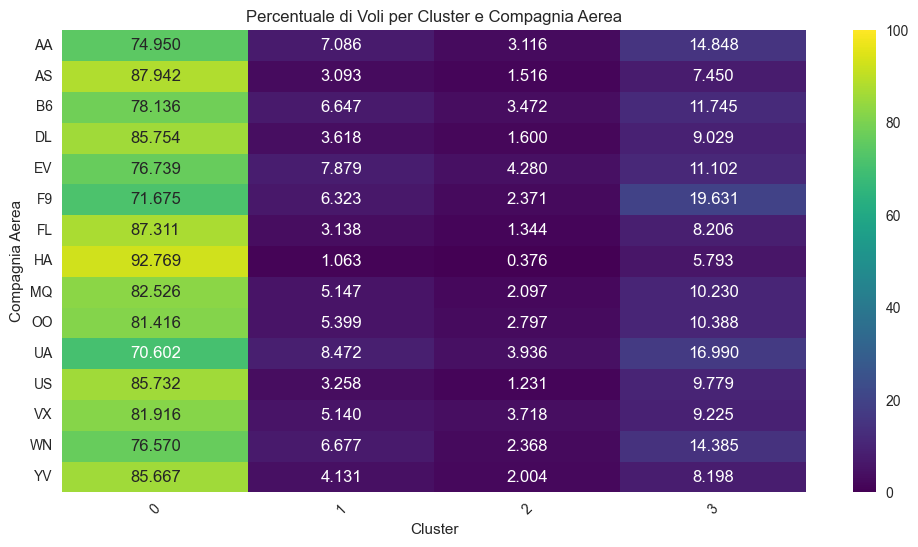

In [77]:
# Creazione della tabella di contingenza (matrice)
contingency_table = pd.crosstab(df['OP_CARRIER'], df['Cluster'])

# Normalizzazione dei valori per ottenere percentuali
contingency_table_percent = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Creazione della heatmap con percentuali
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table_percent, annot=True, cmap='viridis', fmt='.3f', cbar=True, vmin=0, vmax=100)
plt.title('Percentuale di Voli per Cluster e Compagnia Aerea')
plt.xlabel('Cluster')
plt.ylabel('Compagnia Aerea')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='FL_MON', hue='Cluster', palette='viridis')
plt.title('Distribuzione dei Cluster per Mese')
plt.xlabel('Mese')
plt.ylabel('Numero di Voli')
plt.xticks(ticks=range(12), labels=['Gen', 'Feb', 'Mar', 'Apr', 'Mag', 'Giu', 'Lug', 'Ago', 'Set', 'Ott', 'Nov', 'Dic'])
plt.show()

In [ ]:
route_delays = df.groupby(['ORIGIN', 'DEST']).agg({'DEP_DELAY': 'mean', 'ARR_DELAY': 'mean'}).reset_index()
route_delays = route_delays.sort_values(by='ARR_DELAY', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=route_delays.head(10), x='ARR_DELAY', y='ORIGIN', hue='DEST', palette='viridis')
plt.title('Top 10 Rotte con Maggiori Ritardi in Arrivo')
plt.xlabel('Ritardo Medio in Arrivo (minuti)')
plt.ylabel('Rotta')
plt.show()


In [8]:
# Calcolo dei campioni di silhouette
silhouette_vals = silhouette_samples(data_scaled, df['Cluster'])

# Numero di cluster
n_clusters = kmeans.n_clusters
y_lower, y_upper = 0, 0
yticks = []

# Grafico
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[df['Cluster'] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, edgecolor='none')
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(x=silhouette_score(data_scaled, df['Cluster']), color="red", linestyle="--")
plt.yticks(yticks, [f'Cluster {i}' for i in range(n_clusters)])
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot per i Cluster")
plt.show()

KeyboardInterrupt: 

# Clustering gerarchico

In [ ]:
# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['DEP_DELAY', 'ARR_DELAY']])

# Cambiare il tipo di dati per risparmiare memoria
data_scaled = data_scaled.astype('float32')

# Applicazione di KMeans come alternativa ad AgglomerativeClustering
kmeans = KMeans(n_clusters=4)
df['Hierarchical_Cluster'] = kmeans.fit_predict(data_scaled)

C:\Users\dswal\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


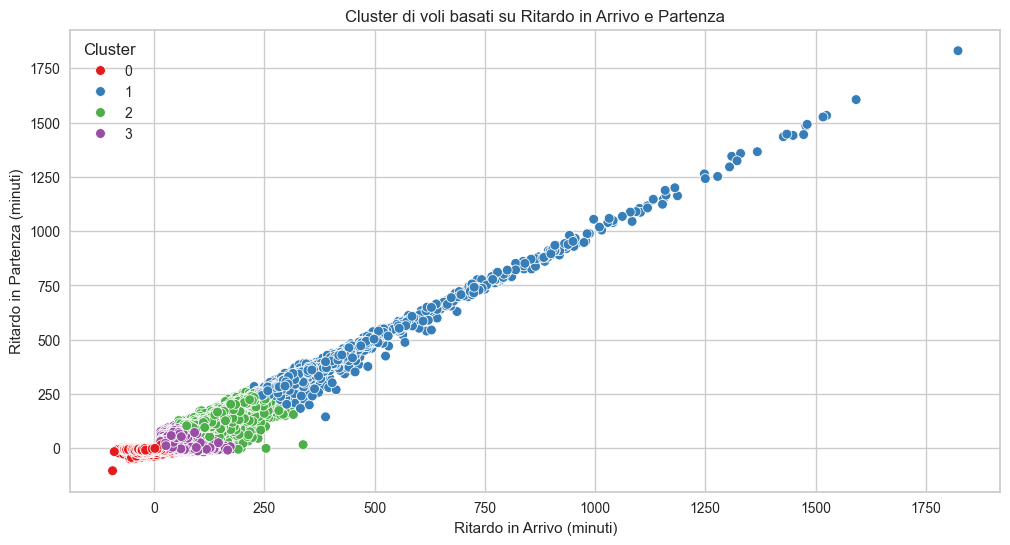

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ARR_DELAY', y='DEP_DELAY', hue='Hierarchical_Cluster', data=df, palette='Set1', s=50)
plt.title('Cluster di voli basati su Ritardo in Arrivo e Partenza')
plt.xlabel('Ritardo in Arrivo (minuti)')
plt.ylabel('Ritardo in Partenza (minuti)')
plt.legend(title='Cluster')
plt.show()